 
    
 # Topic Modeling 


In [1]:
# Data manipulation and modeling libraries
import dask
import pandas as pd
import os
from lxml import etree
from bs4 import BeautifulSoup
import matplotlib
import random
import numpy as np
import joblib

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# Reading files and xml parsing libraries
import glob as glb

In [2]:
import multiprocessing as mp
from multiprocessing import Pool

In [3]:
from dask.distributed import Client
client = Client()
client

/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33555 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33555/status,
Dashboard: http://127.0.0.1:33555/status,Workers: 4
Total threads: 8,Total memory: 31.07 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46389,Workers: 4
Dashboard: http://127.0.0.1:33555/status,Total threads: 8
Started: Just now,Total memory: 31.07 GiB
Comm: tcp://127.0.0.1:34681,Total threads: 2
Dashboard: http://127.0.0.1:42859/status,Memory: 7.77 GiB
Nanny: tcp://127.0.0.1:44145,


In [4]:
# Topic Modeling, in this case matrix factorization can require a lot of memory--For this reason we take
# a sample of the documents if there are too many documents in the dataset.
@dask.delayed
def get_files(month):
    dataset_directory = f'/home/ec2-user/SageMaker/data/WSJ{month}/'
    input_files = os.listdir(dataset_directory)
    return input_files

In [5]:
#We take data from 2021/09 as an example
input_files = get_files(202109).compute()

In [6]:
# We define a function to get the text content that we need from the XML articles available in our dataset
def getxmlcontent(root):
    if root.find('.//HiddenText') is not None:
        return(root.find('.//HiddenText').text)
    
    elif root.find('.//Text') is not None:
        return(root.find('.//Text').text)
    
    else:
        return None

In [7]:
# Set up for multiprocessing--for a single file
def file_content(file):
    try:
        dataset_directory = '/home/ec2-user/SageMaker/data/WSJ201911202111/'
        tree = etree.parse(dataset_directory + file)
        root = tree.getroot()

    except:
        print(file)

    try:
        Finding the relevant text and metadata that we need from the article
        article_id = root.find('GOID').text # ID of article
        article_metadata_text[article_id] = {}
        pubdate = root.find('.//NumericDate').text # Date of article
        text = BeautifulSoup(getxmlcontent(root)).get_text() # Text of article

    except AttributeError:
        Error logging - will show filename if there is a problem processing it
        print("Attribute Error" + file)
        continue
    return article_id, pubdate, text

In [8]:
# Check core count
num_cores = mp.cpu_count()

# When using multiple processes, important to eventually close them to avoid memory/resource leaks
try:
    # Define a thread Pool to process multiple XML files simultaneously
    # Set to num_cores - 1, but may change number of processes depending on instance
    p = Pool(processes=num_cores)
    
    # Apply function with Pool to corpus
    processed_lists = p.map(make_lists, articles)

except:
    print("Error in processing document")
    
finally:
    p.close()

In [9]:
#Convert dictionary to dataframe
df_metadata_text = pd.DataFrame(processed_lists, columns=['article_id', 'pubdate', 'text'])
df_metadata_text

,article_id,pubdate,text
0,2571027231,2021-09-10,\n\n\n\n\n\n\n\n\n\n\n\nCOOK SHARP Slow-brewed...
1,2576886235,2021-09-28,\nWASHINGTON—Before Democratic Rep. Scott Pete...
2,2572825829,2021-09-16,\nA United Nations panel of experts tasked wit...
3,2577752814,2021-09-30,\nNew federal antitrust enforcers want to toug...
4,2571071587,2021-09-10,\nUnited Parcel Service Inc. is getting into s...
...,...,...,...
3831,2577577486,2021-09-30,\nFacebook Inc. is scheduled to testify at a S...
3832,2570233530,2021-09-09,\nWASHINGTON -- The White House is asking Cong...
3833,2569379383,2021-09-06,"\nThe first time they met, Edward Seaman and J..."
3834,2569637033,2021-09-07,\nState Street Corp. agreed to buy Brown Broth...


In [12]:
#Using scikit-learn CountVectorizer--create a vectorizer object which will then be used to create
#a term-document matrix in the next cell. This countVectorizer includes lots of valuable pre-processing parameters
#and optionsincluding like: 

#Set parameters for the tokenization and vocabulary creation. read from files 
vectorizer = CountVectorizer(max_df=.8, min_df=10, stop_words='english', max_features=5000)

# Produce term-document matrix
with joblib.parallel_backend("dask"):
    X = vectorizer.fit_transform(df_metadata_text['text'].tolist())

features = vectorizer.get_feature_names()

len(features)

5000

In [13]:
# Set Parameters
number_of_topics = 30

In [14]:
# Doing our calculations
model = NMF(n_components=number_of_topics, init='random', random_state=0)
with joblib.parallel_backend("dask"):
    W = model.fit_transform(X.toarray())

df_W = pd.DataFrame(W)

H = model.components_
df_H = pd.DataFrame(H)

In [15]:
# Could be using rename here instead if we wanted. 
df_H.columns = features

In [31]:
#Set index to datetime so we can aggregate
df_W.index = pd.to_datetime(df_metadata_text.pubdate)

In [32]:
# Calculating different between earliest and latest date
difference_in_days = (df_W.index.max() - df_W.index.min())/np.timedelta64(1, 'D')

In [33]:
# Automatically resampling our dataframe based on difference in days
if difference_in_days < 31:
    df_W_resampled = df_W.resample('D').sum()
elif difference_in_days < 365:
    df_W_resampled = df_W.resample('W').sum()
else:
    df_W_resampled = df_W.resample('M').sum()

In [34]:
df_H

,000,10,100,11,12,120,13,130,14,15,...,youth,youtube,yu,yuan,zealand,zero,zhang,zhao,zoom,zuckerberg
0,0.207853,0.253645,0.188953,0.246918,0.159279,0.022433,0.038919,0.003923,0.081642,0.103517,...,0.042715,0.023365,0.000000,0.000000,0.009375,0.042995,0.000000,0.000000,0.080752,0.000000
1,0.000000,0.040994,0.054323,0.005367,0.030434,0.000000,0.206059,0.000000,0.039680,0.007377,...,0.065791,0.037709,0.000000,0.000000,0.000000,0.002675,0.000000,0.009577,0.000000,0.265130
2,1.402089,0.386980,0.055766,0.000000,0.000000,0.054524,0.000000,0.008729,0.000000,0.073421,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.075382,0.000000,0.008508,0.000000,0.000000
3,0.507284,0.000000,0.264256,0.000000,0.246333,0.000000,0.000000,0.016628,0.061337,0.030525,...,0.000000,0.002973,0.000000,0.000000,0.000000,0.014295,0.000000,0.000000,0.000000,0.062851
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.003257,0.047985,0.000000,0.000000,0.000000,...,0.072376,0.000000,0.244094,0.246411,0.074226,0.045853,0.338276,0.266112,0.207048,0.000000
5,0.000000,0.102741,0.000000,0.000000,0.000000,0.004989,0.000000,0.000000,0.000000,0.000000,...,0.001138,0.002510,0.000000,0.000000,0.000840,0.000000,0.000000,0.000000,0.005193,0.000000
6,0.000000,0.261561,0.000000,0.579016,0.251935,0.000000,0.077171,0.000000,0.000000,0.060894,...,0.001491,0.030748,0.000000,0.000000,0.000426,0.014646,0.142266,0.349403,0.000000,0.000000
7,0.048720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000137,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002826,0.000000,0.000000,0.000000
8,0.433194,0.301502,0.575980,0.000000,0.768997,0.000000,0.077346,0.004328,0.422692,0.024893,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016735,0.000000
9,1.104020,0.000000,0.301292,0.735773,0.000000,0.000000,0.111298,0.000000,0.093934,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002811,0.126249,0.000000,0.000000,0.000000,0.000000


In [35]:
# Create chart labels based on topics
chart_titles = []

for topic in range(number_of_topics):
    chart_titles.append(df_H.loc[topic].sort_values(ascending=False)[0:10].index.tolist())

In [36]:
# Checking list of chart titles
chart_titles

[['like',
  'just',
  'people',
  'time',
  'family',
  'years',
  'work',
  'way',
  'old',
  'think'],
 ['instagram',
  'facebook',
  'research',
  'teens',
  'users',
  'social',
  'people',
  'researchers',
  'teen',
  'app'],
 ['tax',
  'income',
  'democrats',
  'taxes',
  'house',
  'gains',
  'rate',
  'proposal',
  '000',
  'companies'],
 ['covid',
  '19',
  'people',
  'vaccinated',
  'delta',
  'variant',
  'health',
  'virus',
  'cases',
  'patients'],
 ['china',
  'chinese',
  'beijing',
  'xi',
  'government',
  'foreign',
  'companies',
  'trade',
  'country',
  'evergrande'],
 ['iran',
  'nuclear',
  'agency',
  'iaea',
  'deal',
  'access',
  'uranium',
  'talks',
  'material',
  'equipment'],
 ['ms',
  'theranos',
  'holmes',
  'trial',
  'blood',
  'merkel',
  'meng',
  'women',
  'told',
  'huawei'],
 ['judge',
  'court',
  'stock',
  'parties',
  'cases',
  'clerk',
  'case',
  'publicly',
  'filed',
  'decisions'],
 ['travel',
  'canada',
  'border',
  'travelers'

In [37]:
# Verifying that our dataframe is resampled correctly
df_W_resampled

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
pubdate,,,,,,,,,,,,,,,,,,,,,
2021-09-01,29.167552,6.587063,6.950046,11.096775,6.941199,3.467736,3.941044,0.793986,9.281017,6.338670,...,16.435550,5.113523,2.903401,5.535391,1.209097,5.647957,7.187805,8.254715,3.542215,11.135683
2021-09-02,24.366931,4.376272,5.038112,6.678818,4.839294,3.326445,3.150720,1.114271,2.599940,4.016603,...,10.744544,5.121199,2.403285,5.869452,1.823207,7.818287,8.052544,8.094659,1.725342,10.751051
2021-09-03,24.220549,6.890574,9.339083,15.911776,6.427736,3.643939,6.747277,0.860295,7.037834,4.649212,...,13.493958,9.843198,2.699808,5.672494,1.369346,8.562592,3.496133,7.525877,3.381040,13.424552
2021-09-04,38.263568,6.940054,3.068364,7.617144,2.912889,1.543313,6.308411,0.347203,2.261964,2.001190,...,5.797382,8.093522,1.686651,4.190180,0.635292,5.440832,2.140865,4.093371,1.735984,8.958020
2021-09-05,2.585875,0.626200,3.359828,2.840288,2.140885,0.414474,0.189491,0.199091,2.219529,3.417039,...,3.284000,3.292485,0.456047,1.823491,0.140380,1.337712,0.086071,2.104690,0.611025,1.133516
2021-09-06,18.083324,5.409092,0.611606,3.596114,1.948782,1.270643,2.665715,0.284153,1.943740,2.452834,...,6.233634,7.105089,0.561774,1.800779,0.824902,0.947300,1.362793,3.078442,0.891785,4.409087
2021-09-07,25.749318,6.815568,4.546199,8.779213,6.570192,11.414741,2.922337,0.669336,5.067180,3.659147,...,8.707435,10.815882,2.613118,5.972744,1.194180,4.740874,8.344729,10.071192,2.995722,15.621490
2021-09-08,27.547858,7.672716,5.534623,13.366338,5.390843,15.070720,5.600727,1.175148,5.068052,3.669903,...,7.319762,12.984145,2.327224,5.222668,2.151350,6.471145,7.740989,8.899805,4.960594,17.105389
2021-09-09,34.093229,8.893182,4.413505,11.768795,5.096609,2.477281,6.094621,0.920212,3.519423,5.908794,...,9.734379,9.670239,2.675008,7.678451,1.976436,8.792200,2.692470,5.741223,3.571772,13.579995


In [38]:
# Setting figure size
fig_length = 10
fig_width = 20

/home/ec2-user/SageMaker/.conda/envs/sample_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


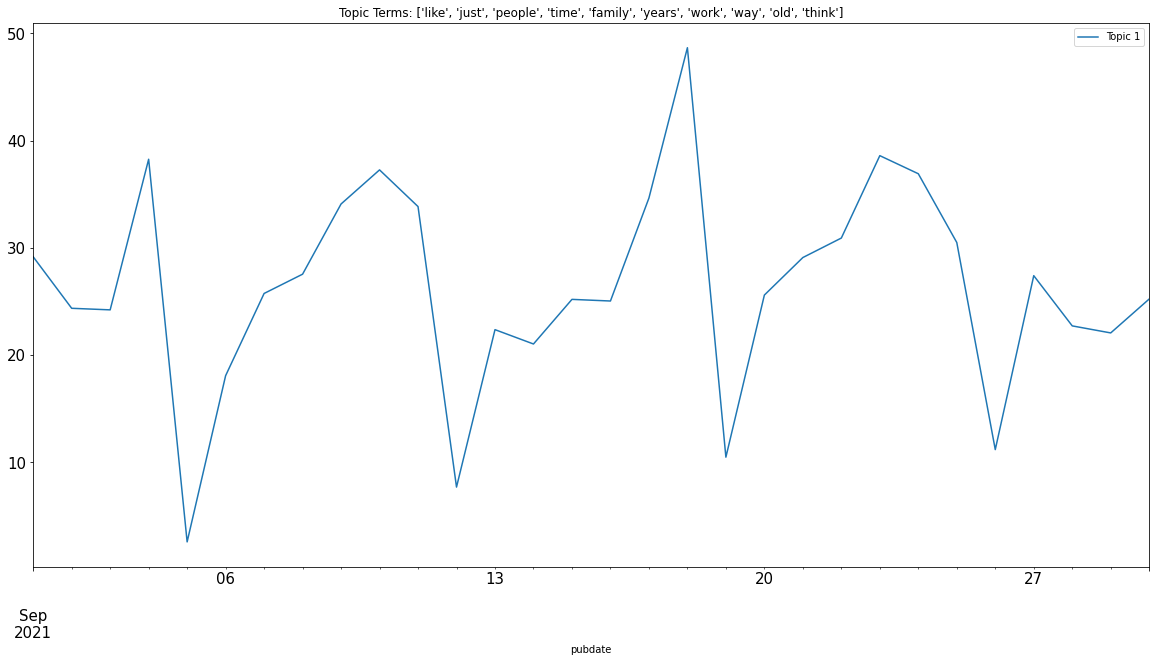

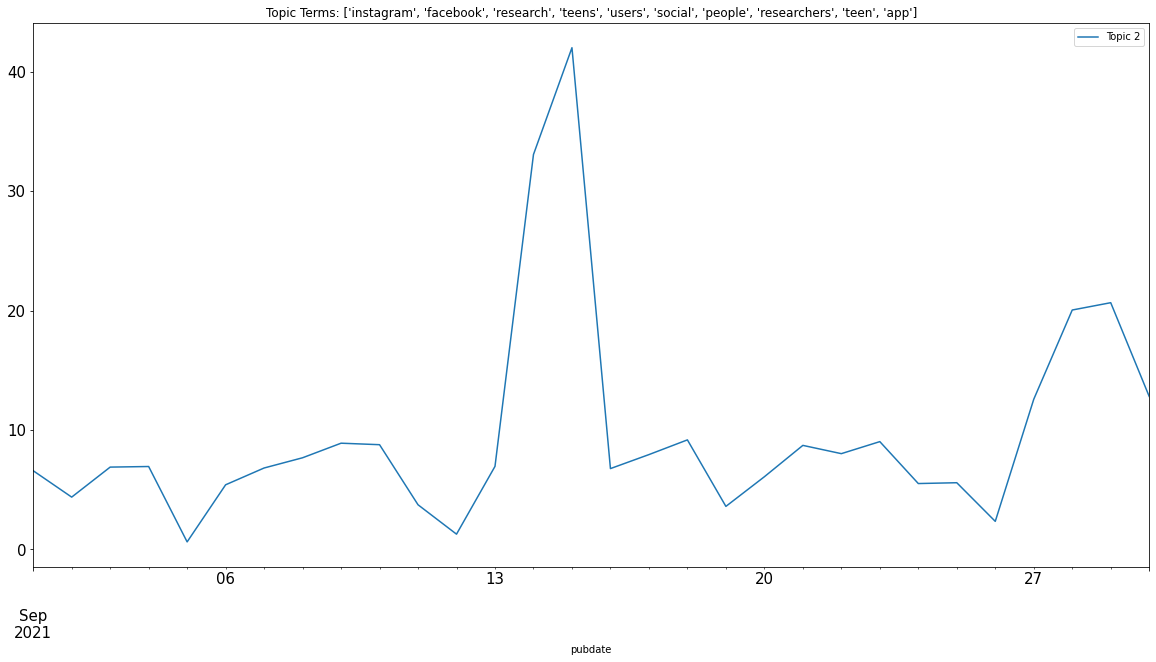

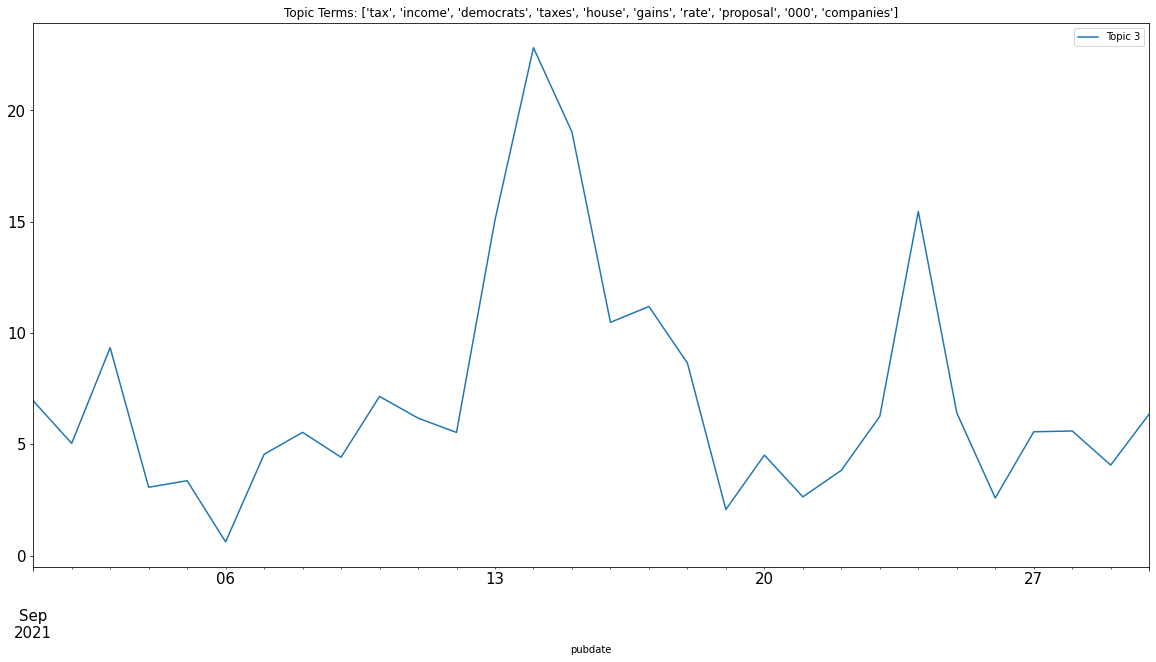

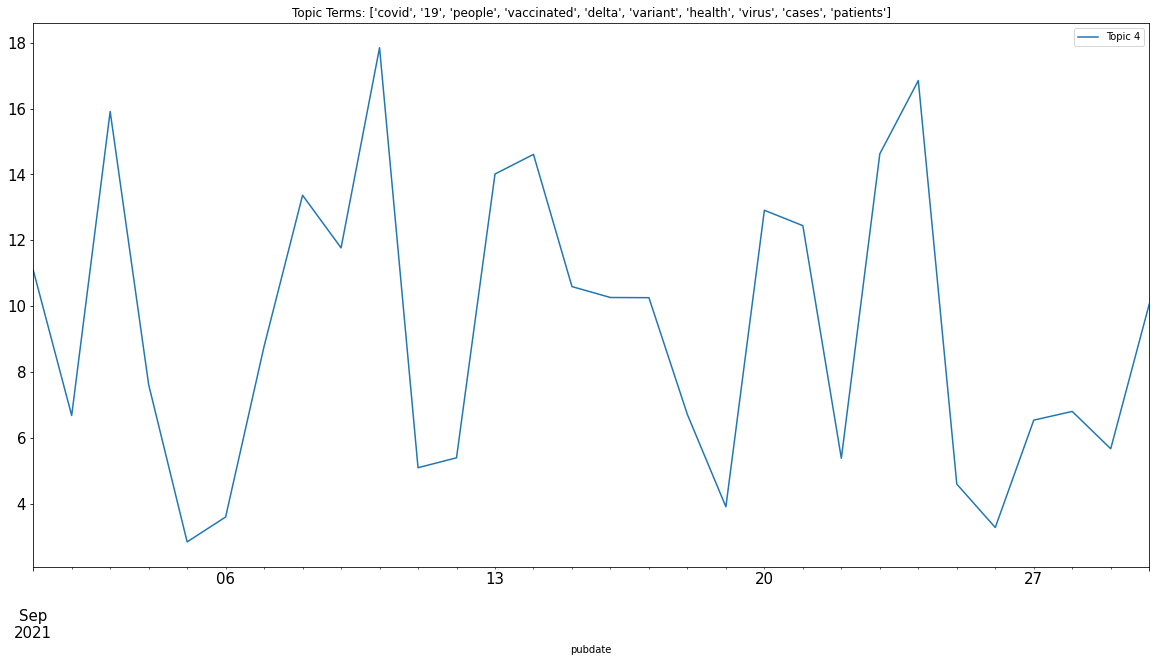

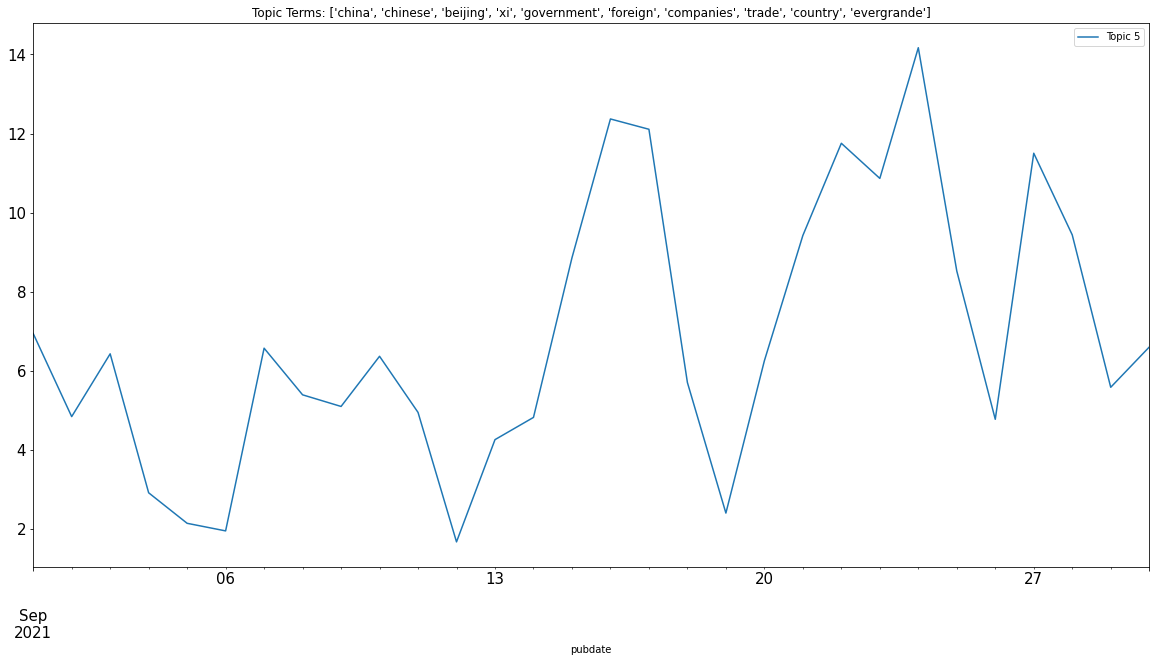

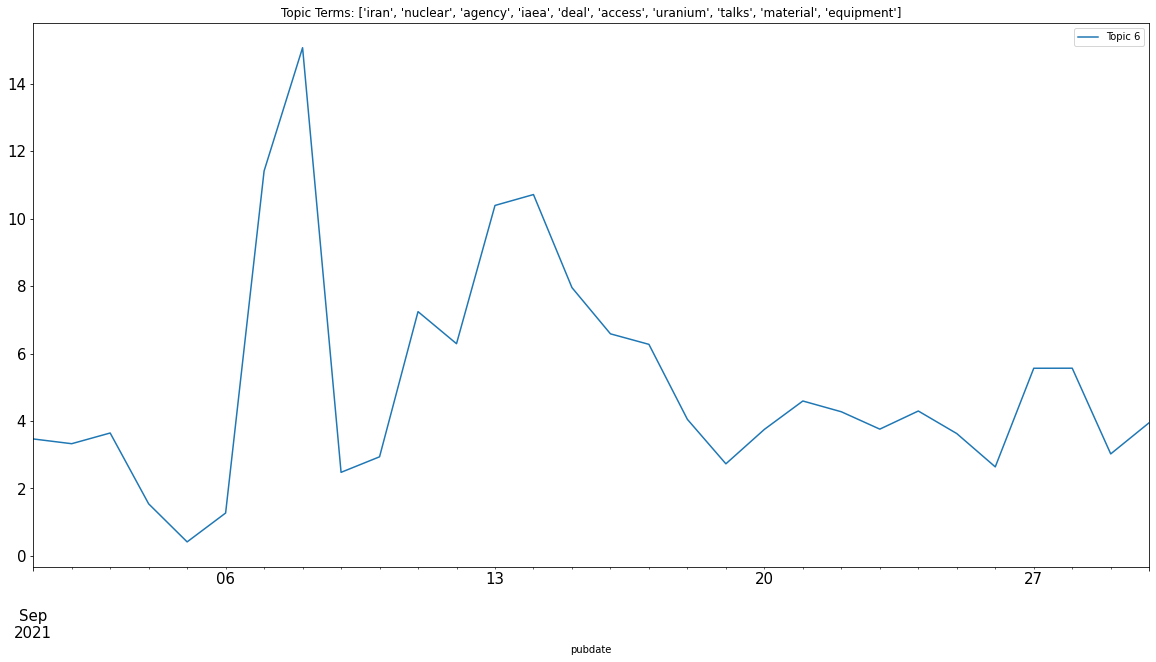

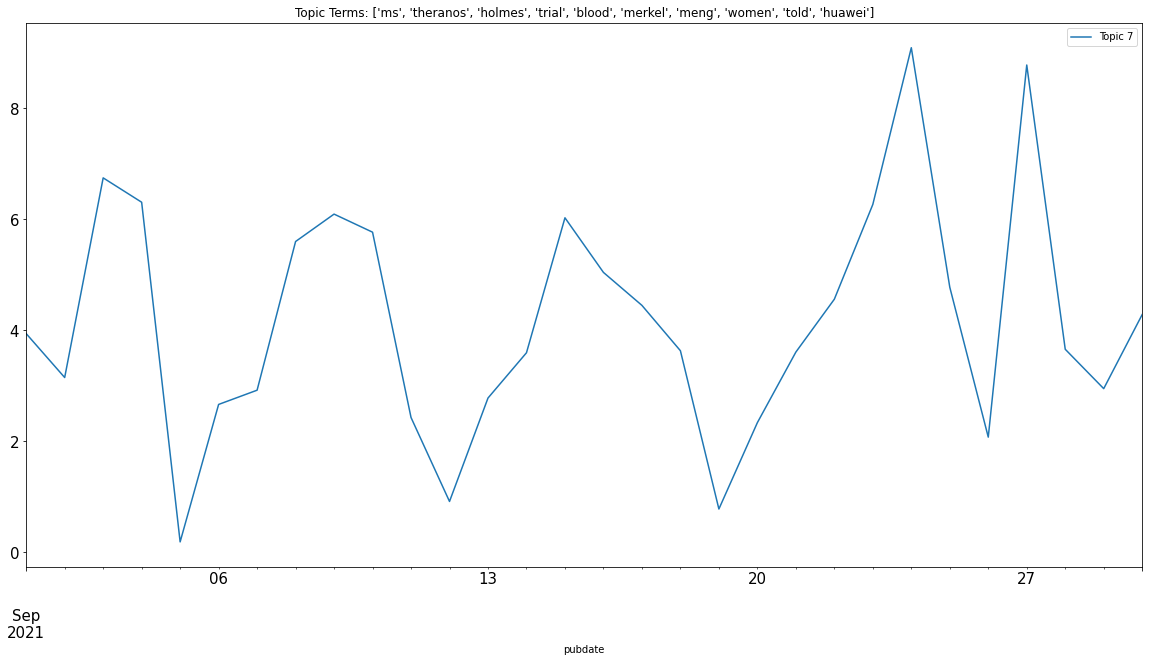

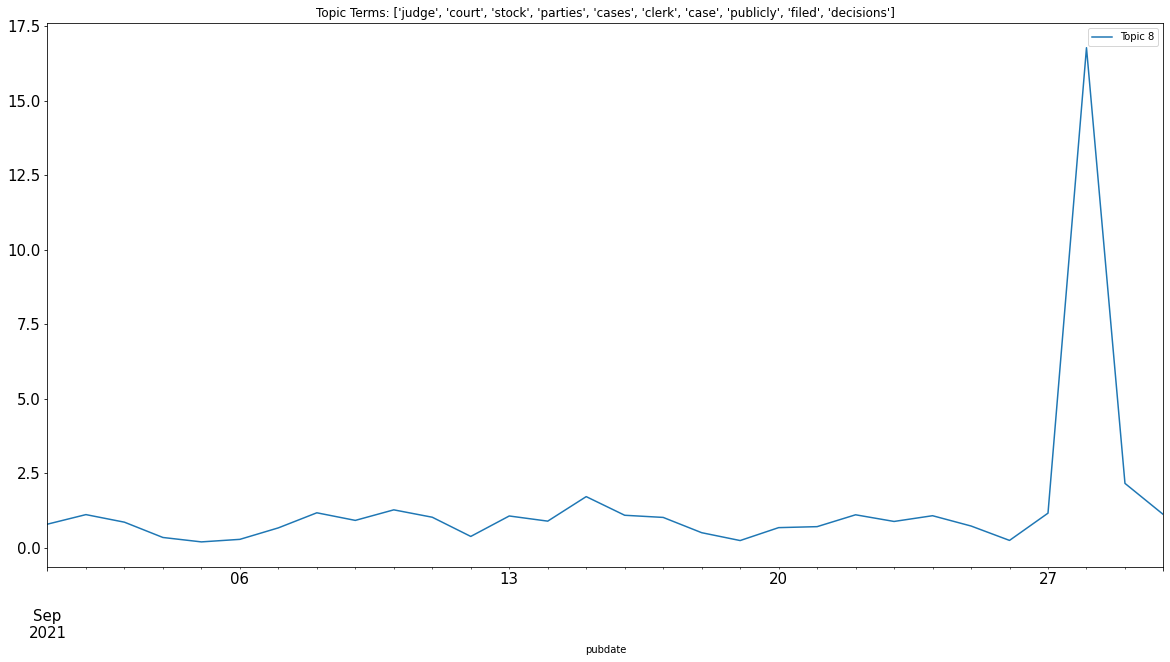

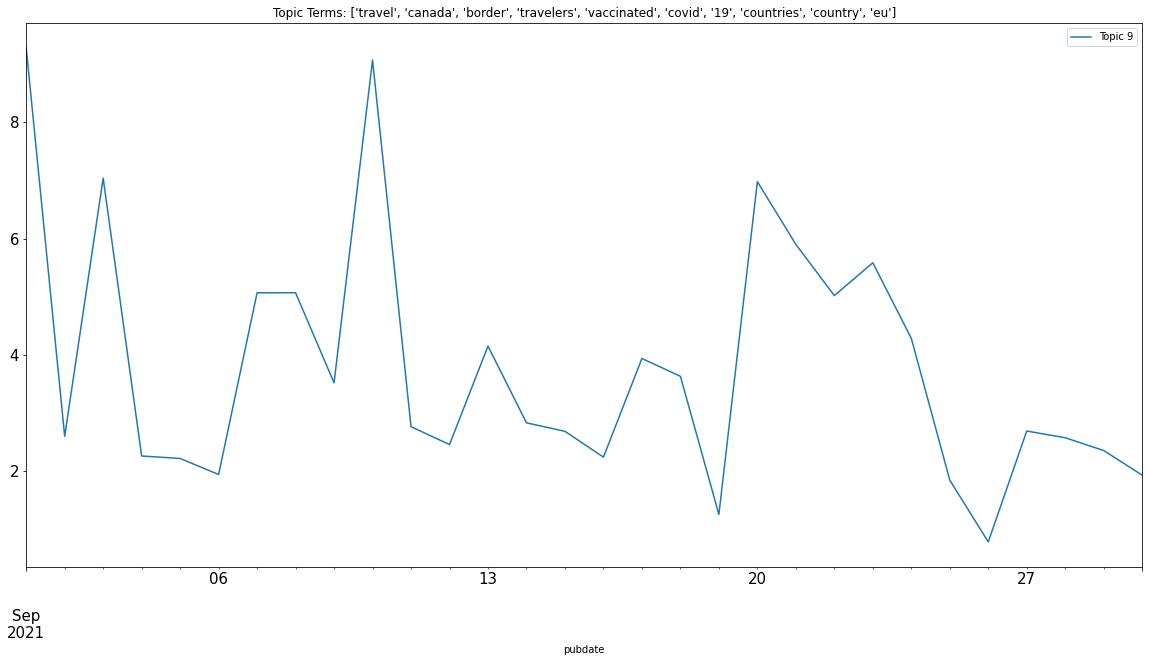

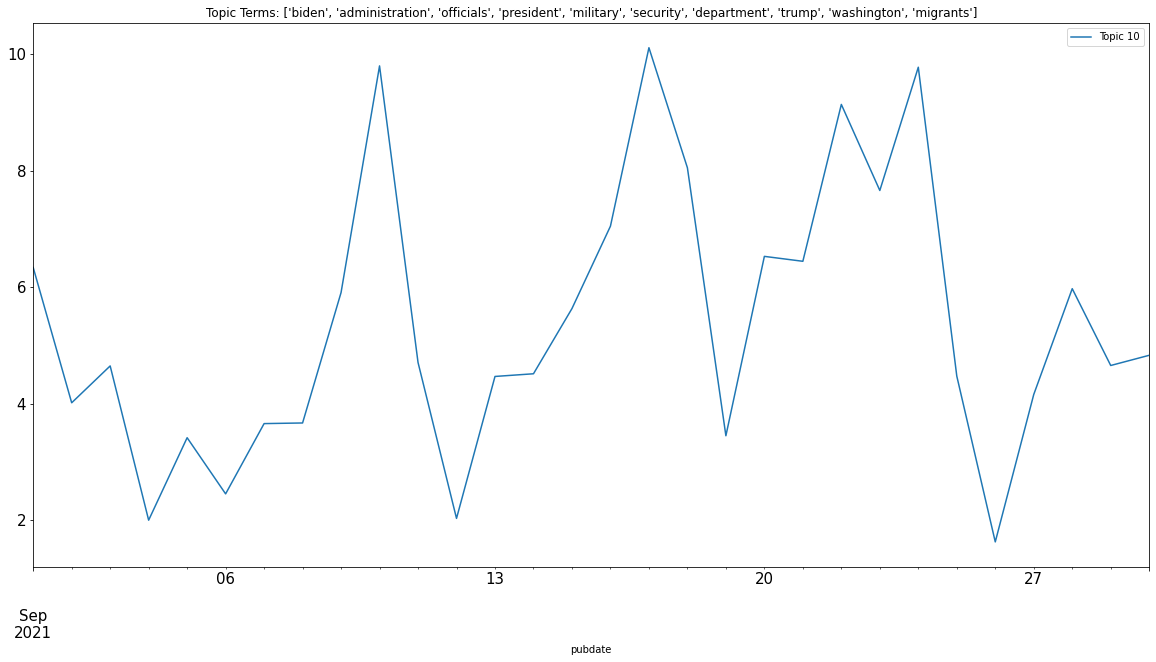

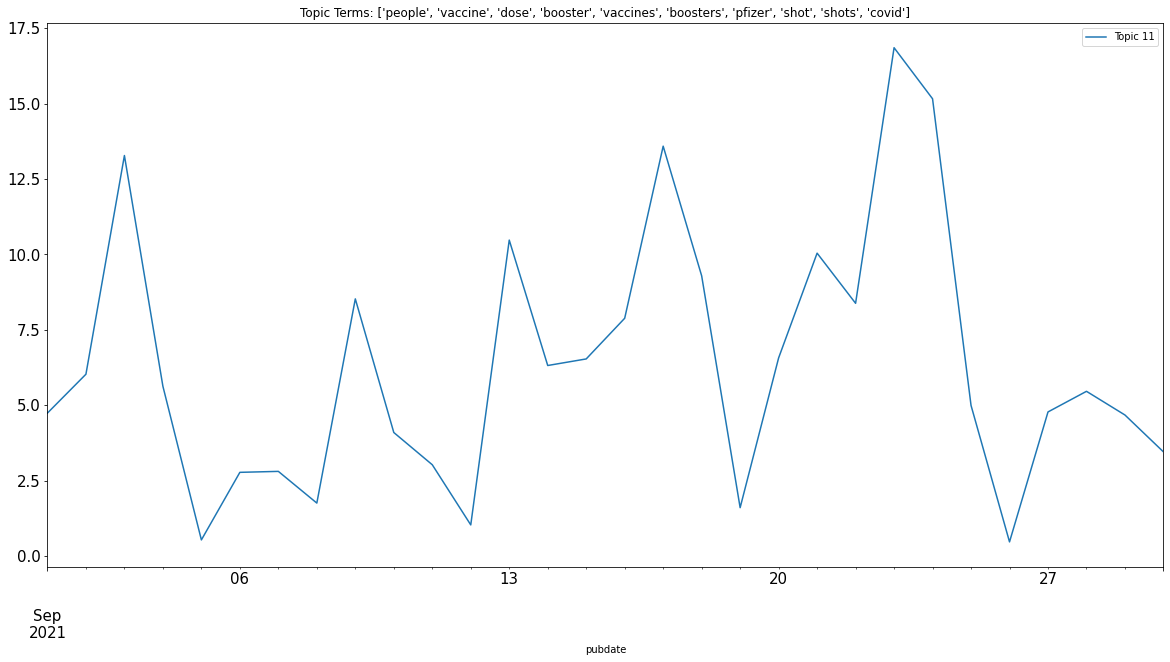

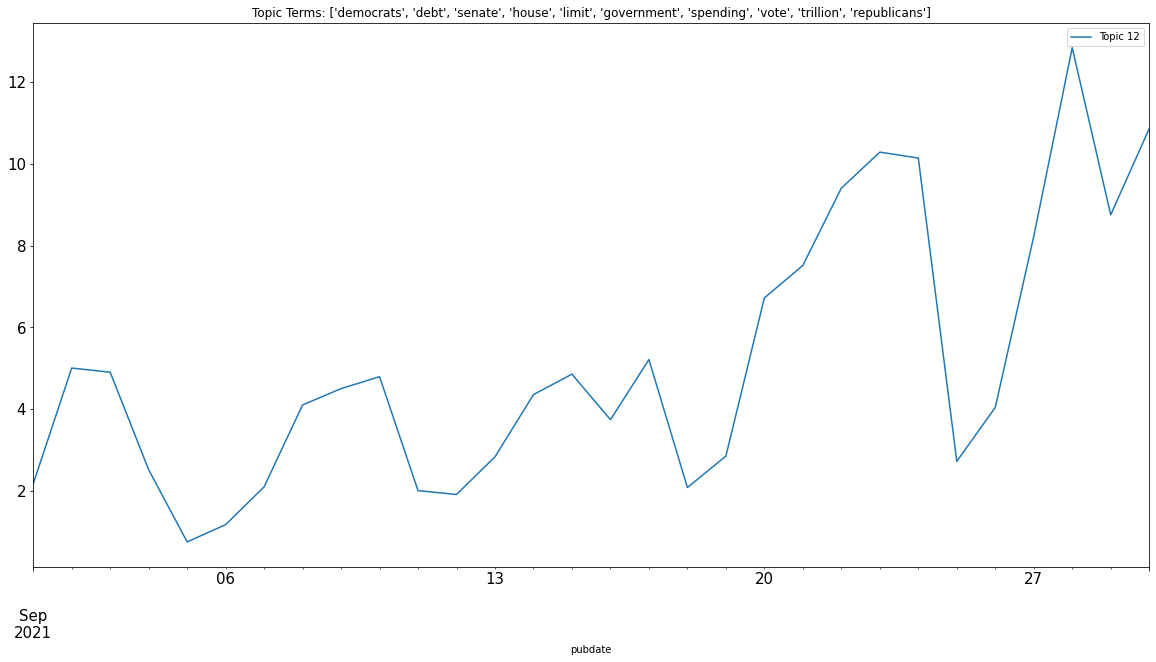

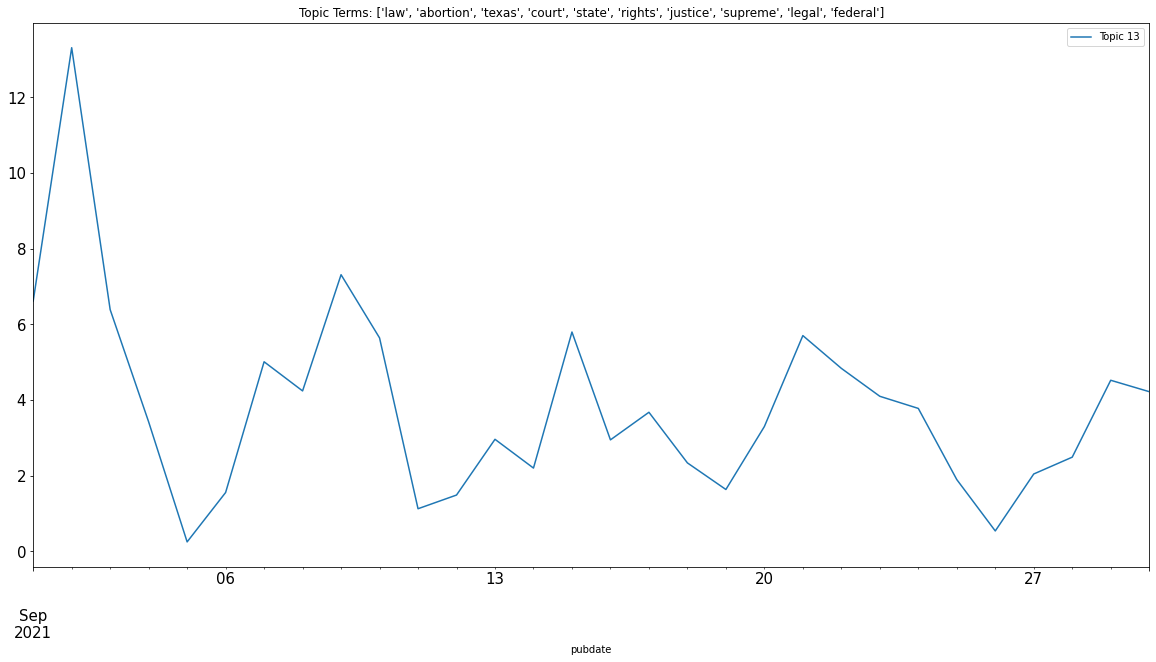

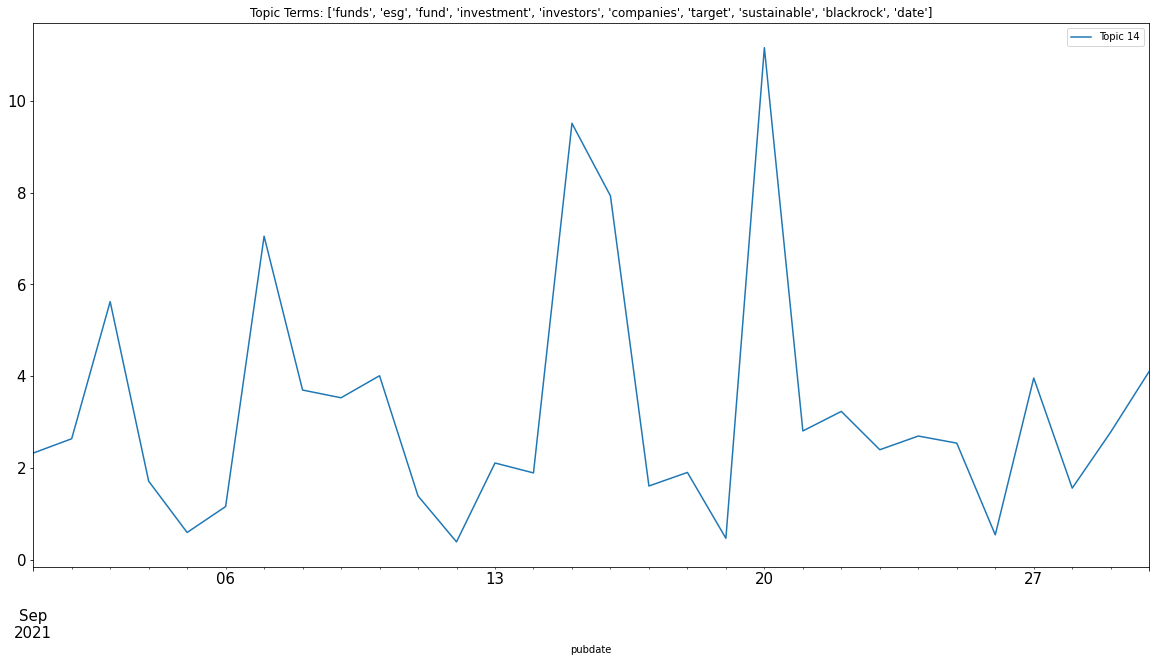

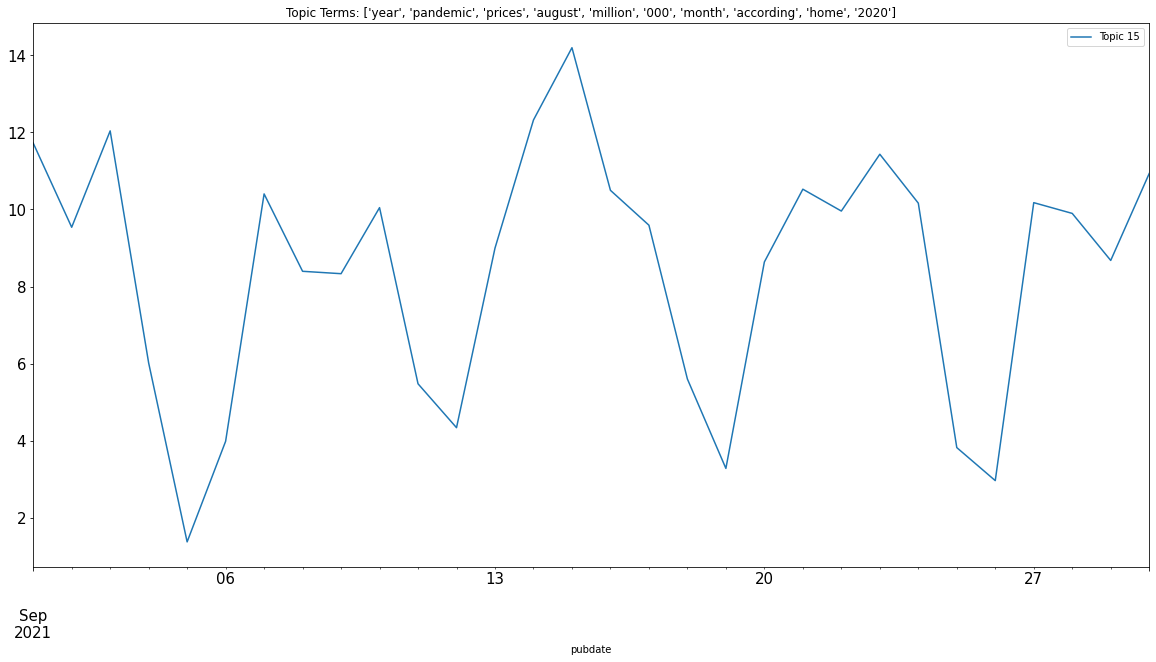

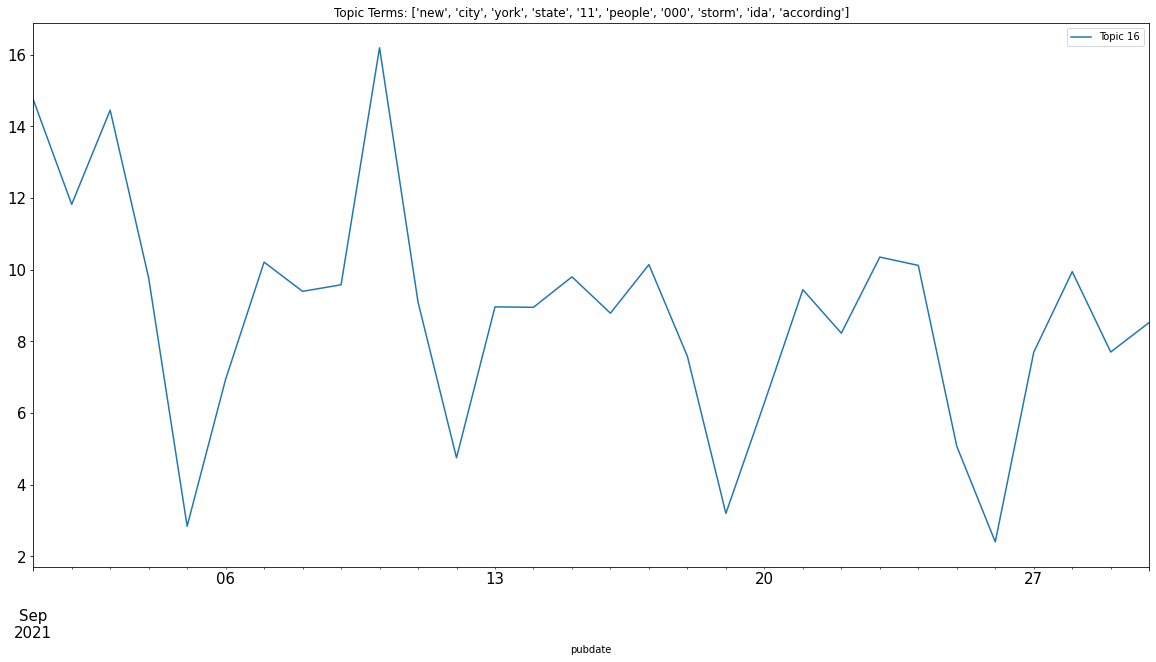

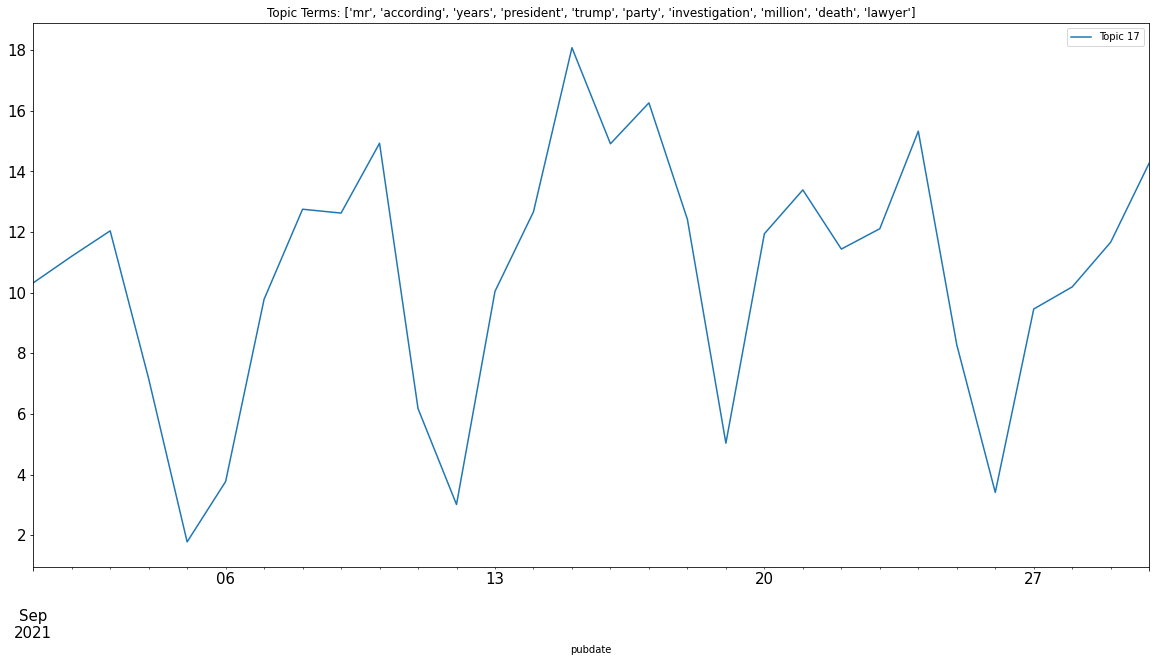

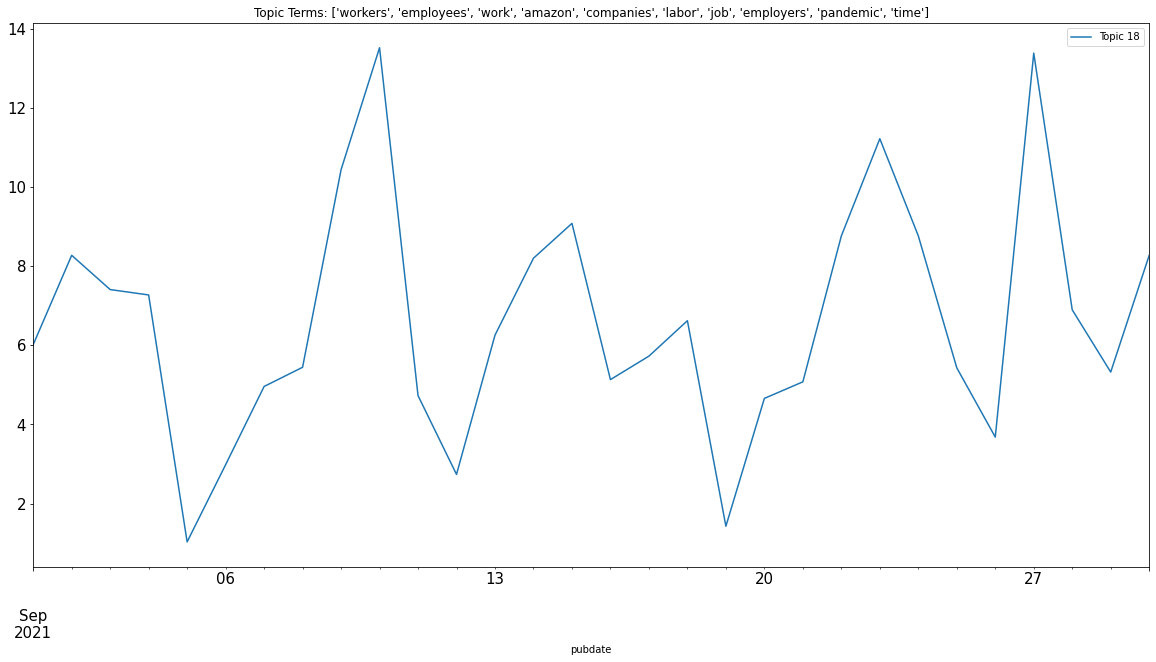

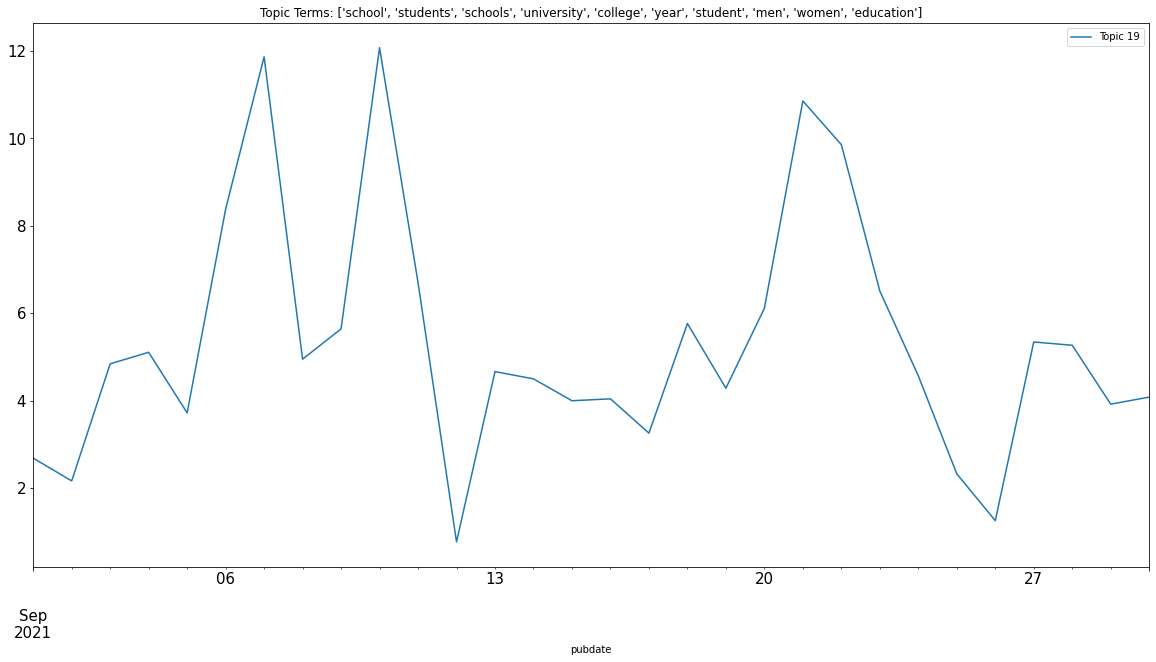

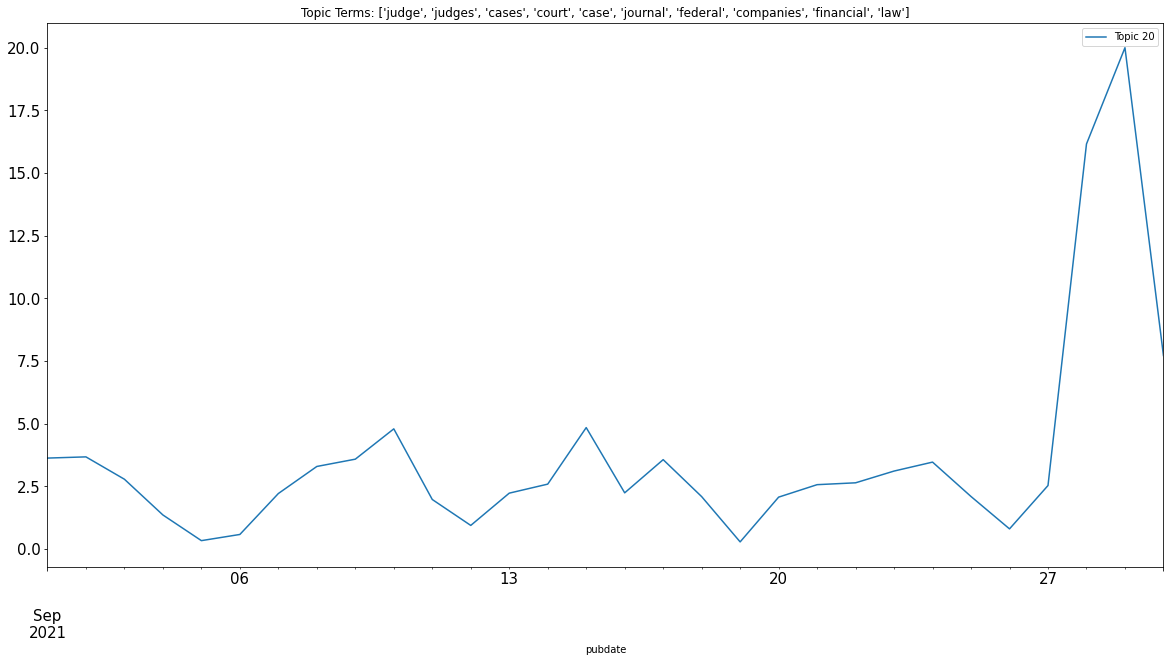

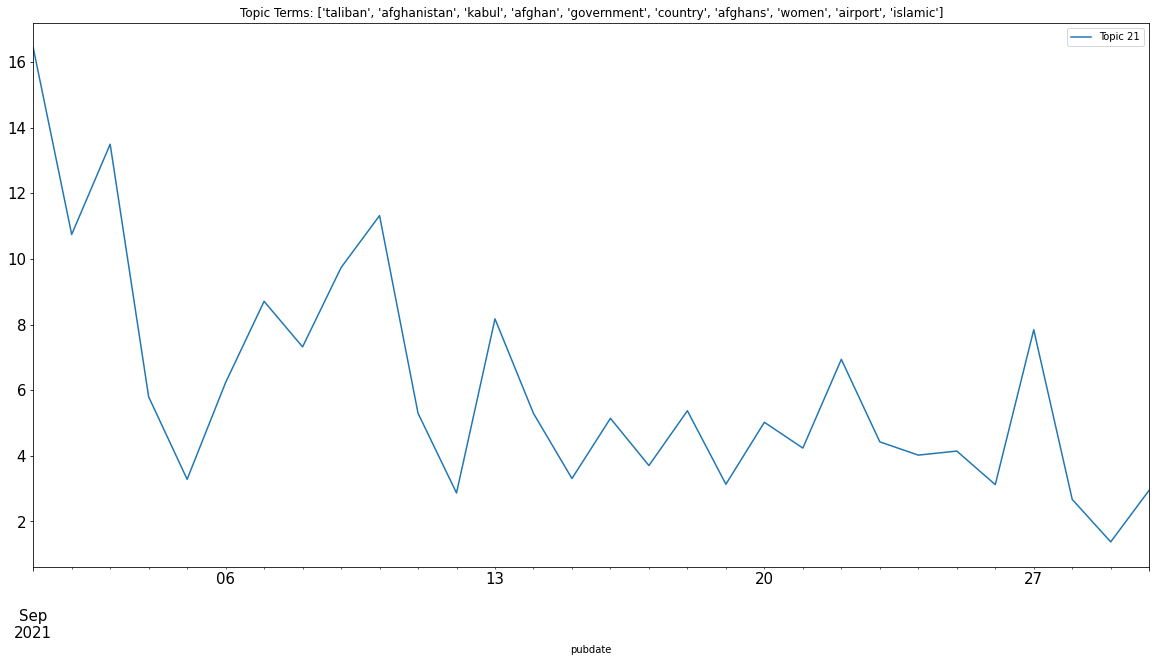

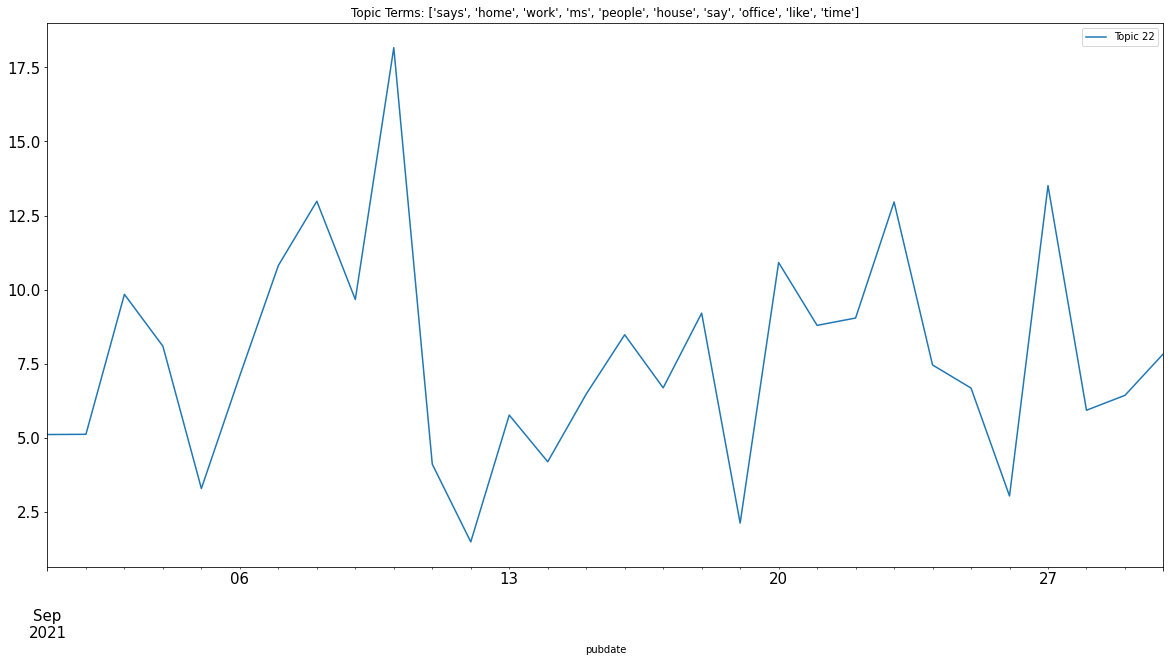

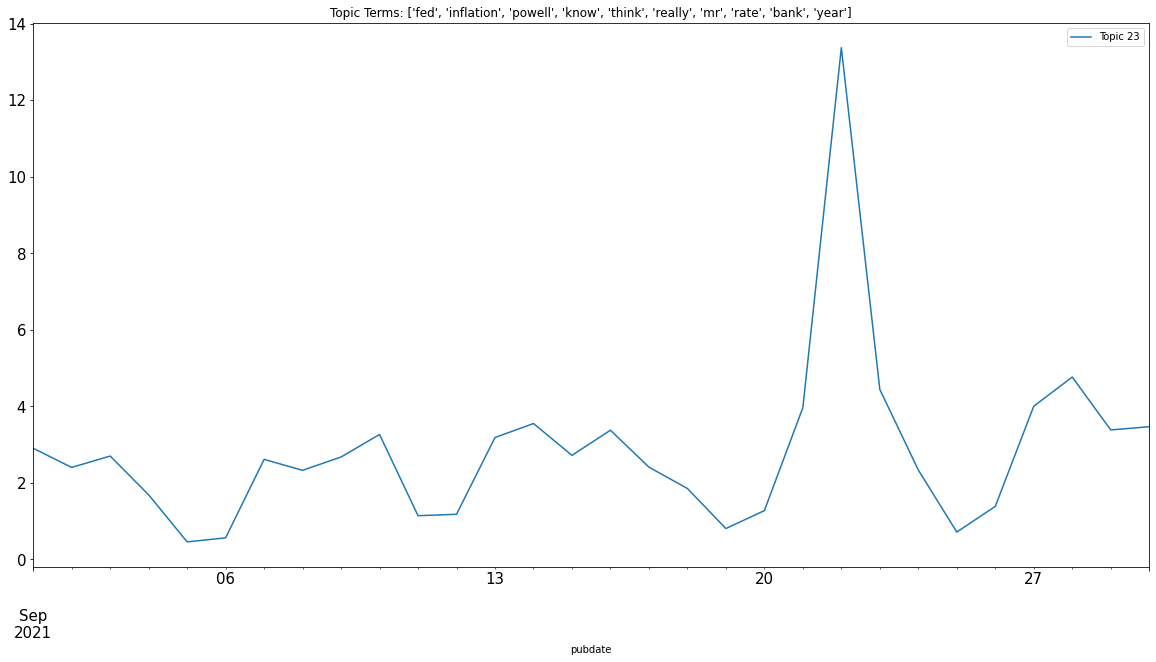

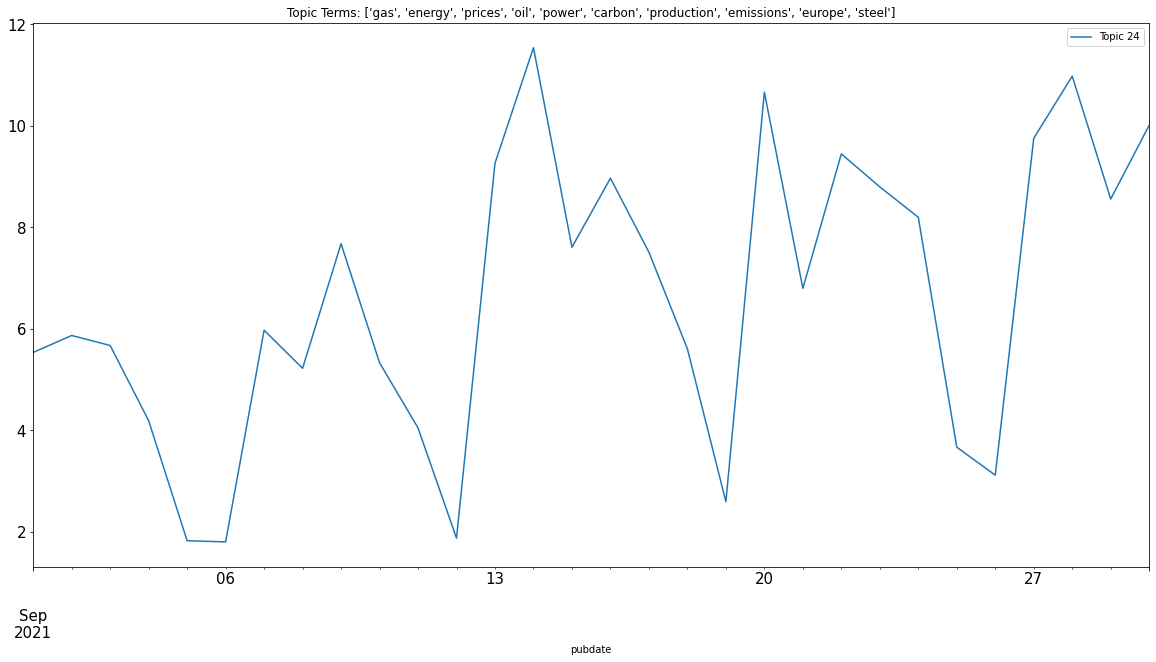

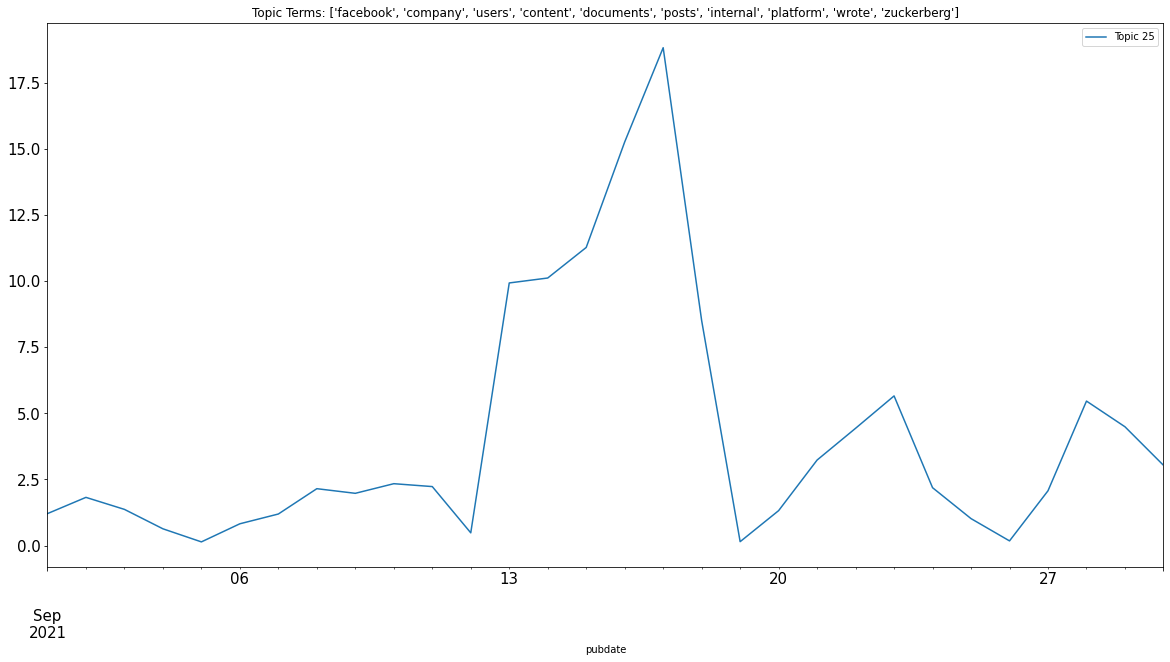

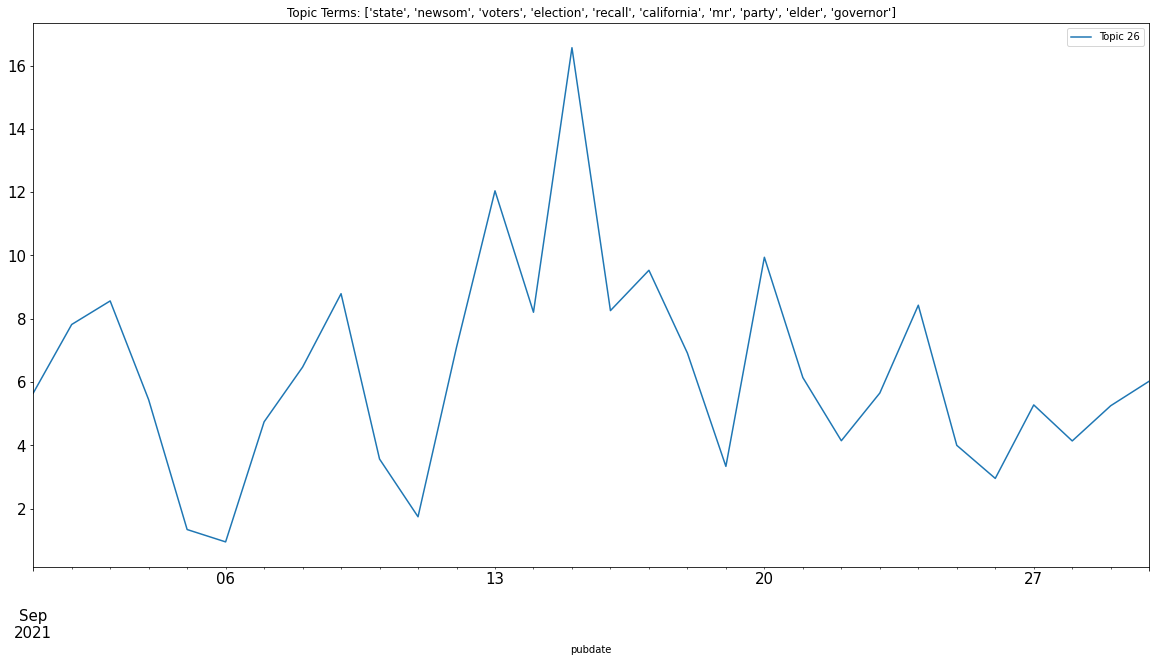

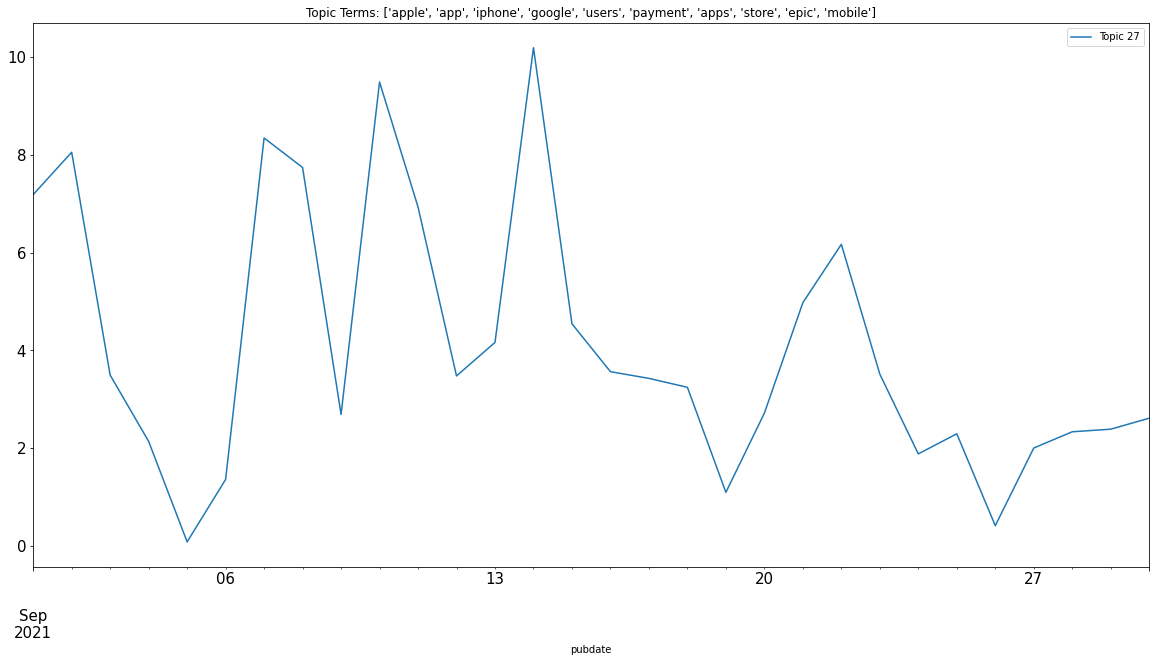

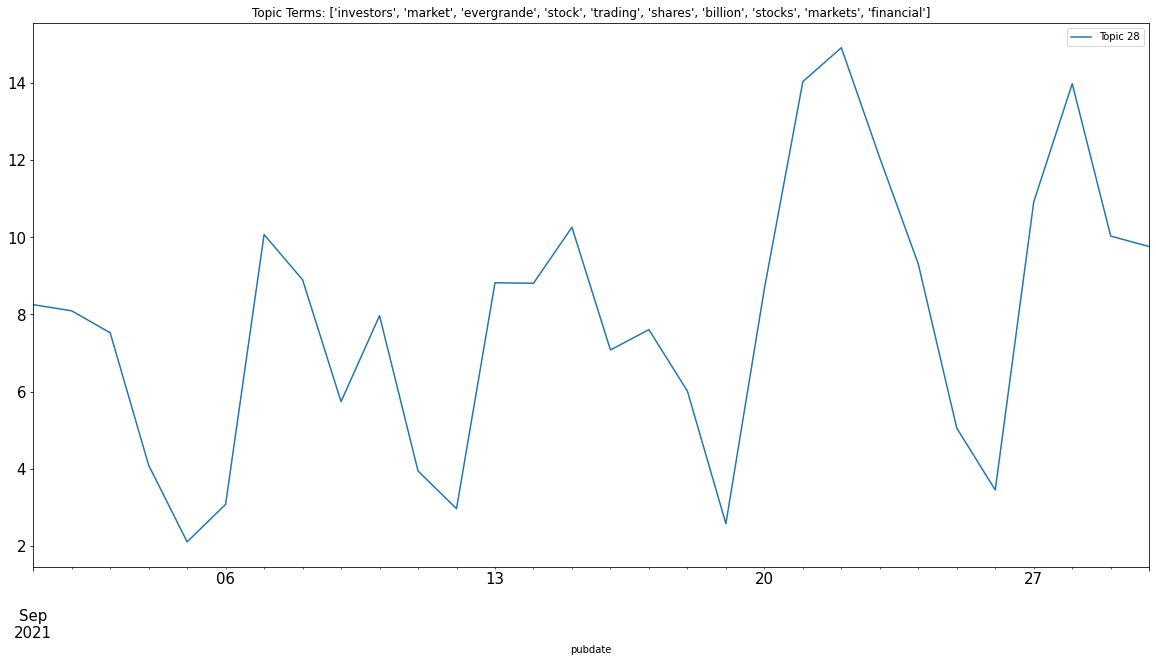

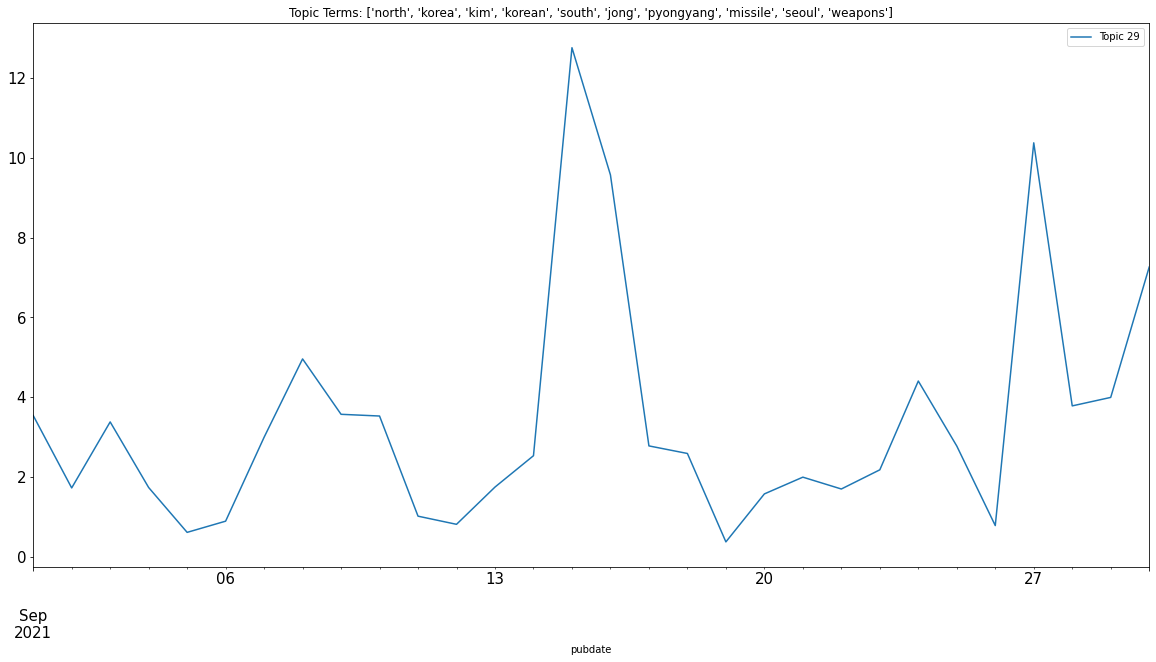

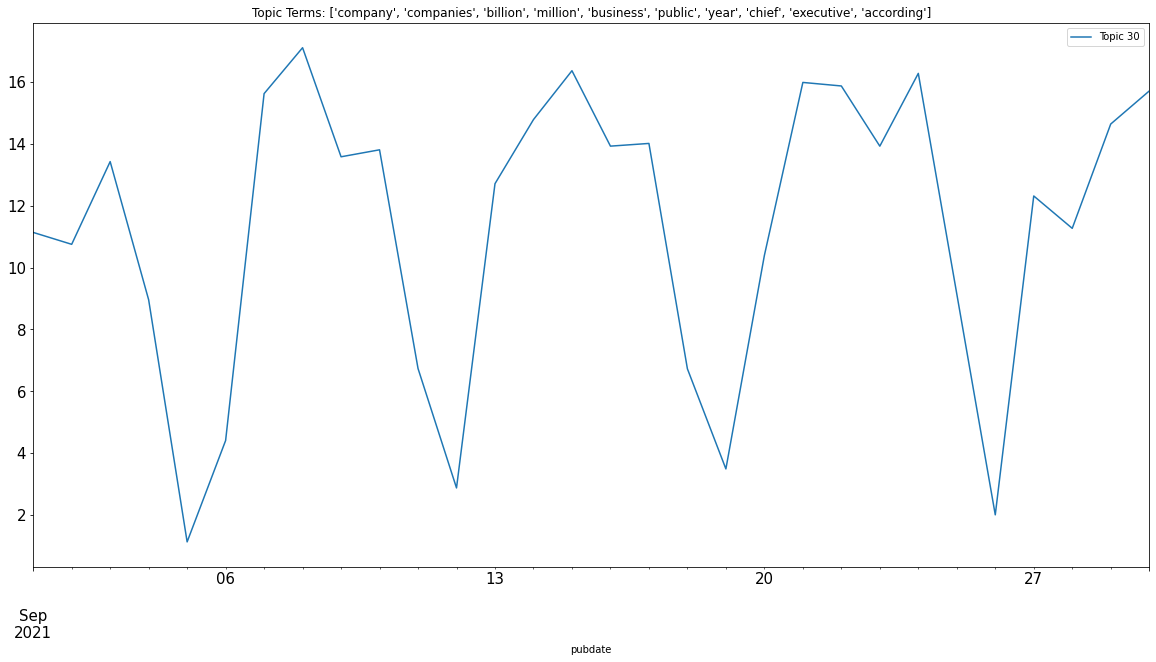

In [39]:
# Generating individual graphs based on each of our topics
for topic in range(number_of_topics):
    chart_title = 'Topic Terms: ' +str(df_H.loc[topic].sort_values(ascending=False)[0:10].index.tolist())
    
    ax = df_W_resampled[[topic]].plot(title=chart_title, figsize=(fig_width, fig_length), fontsize=15)
    ax.legend(['Topic ' + str(topic + 1)])